# Time Series Forecasting with SoaM

In this notebook we will show how to make predictions and persist them using SoaM Forcaster.

In [1]:
import io

from darts import models
import matplotlib.pyplot as plt
from muttlib.dbconn import PgClient
import pandas as pd
import requests

from soam.cfg import get_db_cred
from soam.forecaster import Forecaster
from soam.savers import CSVSaver, DBSaver
from soam.forecast_plotter import ForecastPlotter
from soam.mail_report import MailReport
from soam.slack_report import SlackReport

Importing plotly failed. Interactive plots will not work.


## Fetch sample data

For the following examples we will download the following public dataset:

In [2]:
url = "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv"
df = pd.read_csv(url)
df.tail()

,ds,y
288,2016-01-01,400928
289,2016-02-01,413554
290,2016-03-01,460093
291,2016-04-01,450935
292,2016-05-01,471421


We plot the sample data:

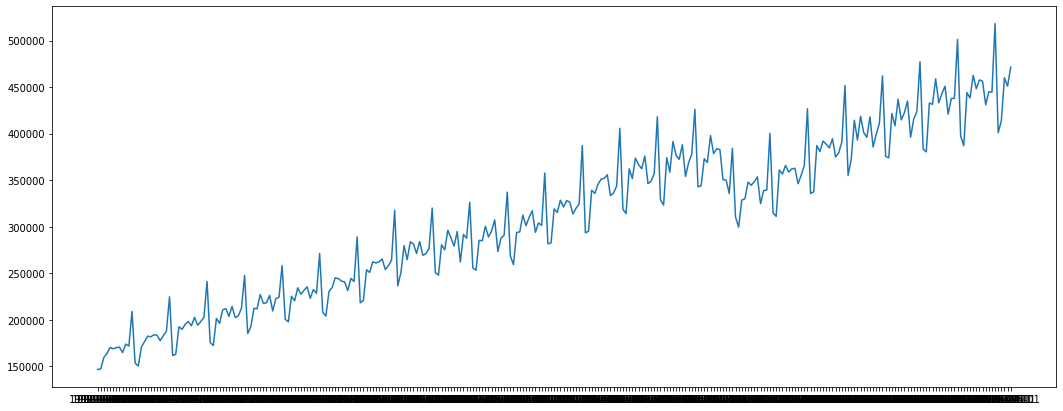

In [3]:
fig = plt.figure(figsize=(18,7))
plt.plot(df.ds, df.y)

## Forecasting
Now we have to create a model, for this we use [Darts models](https://github.com/unit8co/darts/tree/master/darts/models).

In this example we will use the fbprophet model provided by Darts.

In [4]:
my_model = models.Prophet(weekly_seasonality=False, daily_seasonality=False)

Then we create a `Forecaster` and pass the Darts model to the constructor. 

In [5]:
forecaster = Forecaster(my_model)

Now we use the `run` method of the forecaster instance that we just created to fit the model to the data and make a prediction.  

The `run` method requires as input a Pandas DataFrame with at least a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.  
[`Multivariate`](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html#darts.models.forecasting_model.MultivariateForecastingModel) models also accept other timeseries appart from the one in the `y` column we just mentioned. 

Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.

The output lenght parameter is passed to indicate the number of points that we want to predict in the future.

*Note that some models may fails if output lenght is larger than input lenght.*


In [6]:
predictions = forecaster.run(raw_series=df, output_length=7)

Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.


In [7]:
df["ds"] = pd.to_datetime(df.ds, infer_datetime_format=True)
dfp = df.set_index("ds")
predictions["forecast_date"] = pd.to_datetime(predictions.forecast_date, infer_datetime_format=True)
predp =  predictions.set_index("forecast_date")

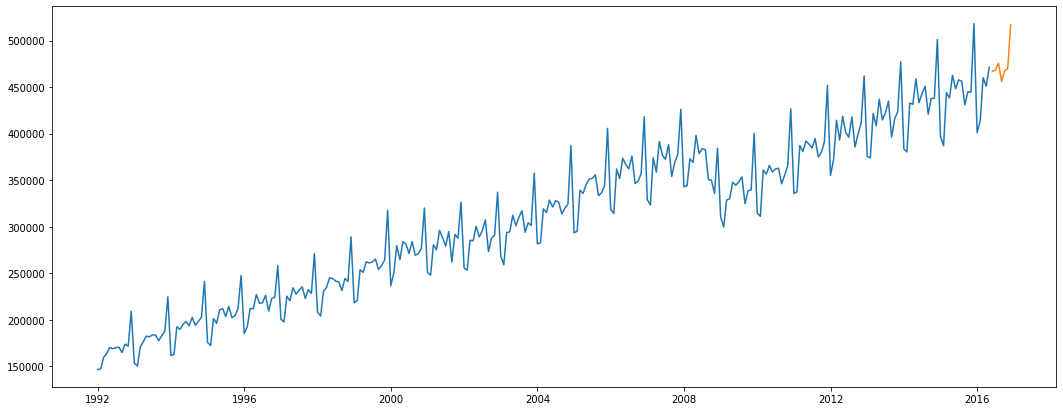

In [8]:
## Add labels
fig = plt.figure(figsize=(18,7))
plt.plot(dfp.index, dfp.y)
plt.plot(predp.index, predp.yhat)
plt.show()

## Persisting the results

After training the model and performing the forecast you may want to save the prediction.  For that purpose we created `Saver` class, for which we have the following implementations:
- `CSVSaver`: It's used to save the outputs to CSV files. It needs a path to the destination directory.
- `DBSaver`: Receives [Muttlib](https://gitlab.com/mutt_data/muttlib/-/blob/master/muttlib/dbconn.py) a database client.  
For this saver to work you need to setup the SQLAlchemy connection string and have the models created in the target DB with the Alembic migrations as described in the [`README.md`](../../README.md).


### Store in CSV file
You can easily store the ouput in CSV as follows:


In [ ]:
saver = CSVSaver("/tmp/soam_run/")
saver.save_forecaster(forecaster)

### Store in DB

To use the `DBSaver` we need to create the database client that it will use.  
Before we start we need to setup the database connection in `settings.ini` file.

In [ ]:
db_cred = get_db_cred("../../soam/settings.ini")
db = PgClient(**db_cred)

With the database client we can now create the `DBSaver` object that will be passed to the `save` method of the forecaster to persist the data.  

*Note that more complex outputs may need changes in the DB schema (see [`data_models.py`](./soam/data_models.py)).*


In [ ]:
saver = DBSaver(db)
saver.save_forecaster(forecaster)

## Plotting and reporting

When it comes to plotting, we offer the `ForecastPlotter` class, with sensible defaults for **daily** and **hourly** forecast plots. You'll have to create this object by defining an **output folder directory** where the plots will be saved and the **name of the metric** you want to plot.

In this example we'll format and plot a csv with revenue data:

In [9]:
df = pd.read_csv('../data/revenue.csv')
df["ds"] = df["date"]
df = df[df["game"] == "battletanksbeta"]
df = df.groupby("ds").mean().reset_index()
df["y"] = df["revenue"]
df = df.drop(columns=["row_count", "requests", "impressions", "clicks", "revenue"])

df.tail()

,ds,y
56,2020-07-12,103.440426
57,2020-07-13,101.425338
58,2020-07-14,96.729440
59,2020-07-15,90.514557
60,2020-07-16,89.678114


In [10]:
revenue_model = models.Prophet(weekly_seasonality=True)

In [11]:
forecaster = Forecaster(revenue_model)
predictions = forecaster.run(raw_series=df, output_length=7)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now that we have our predictions, we can create the plot:

TypeError: '>' not supported between instances of 'int' and 'list'

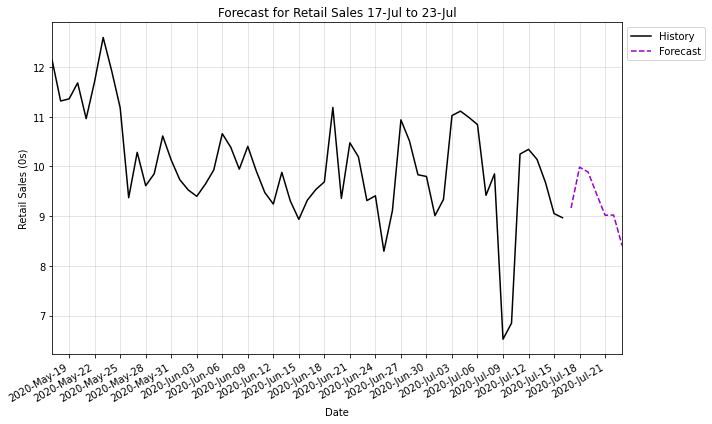

In [23]:
forecast_plotter = ForecastPlotter('.', 'Retail Sales')

plot_fn = forecast_plotter.plot(forecaster.raw_series, forecaster.prediction)

`forecast_plotter.plot` will return the filename of the generated figure, which we can use for **Reporting**. SoaM includes two types of reporting:

* Mail Report: send the forecast plot to one or more mail recipients.
* Slack Report: sends a summary of the forecast values and its plot to a certain Slack channel.

### Mail Report

The class `MailReport` has everything you need for sending an email report, you'll just need a SMTP enabled email account. 

Your gmail account should have 2FA (Two-Factor Authentication) and Third-Party apps permissions active, with that you'll be able to create an App Pasword for your smtp settings. [Official Gmail guide](https://support.google.com/mail/answer/185833?hl=en)

Make sure to add your SMTP credentials to `settings.ini`. If using a Gmail account, you won't have to modify the `SMTP_HOST` and `SMTP_PORT`.

In [13]:
end_date = max(df["ds"])

mail_reporter = MailReport(["youremail@mail.com"], "Revenue")

mail_reporter.send(end_date, plot_fn)

NameError: name 'plot_fn' is not defined

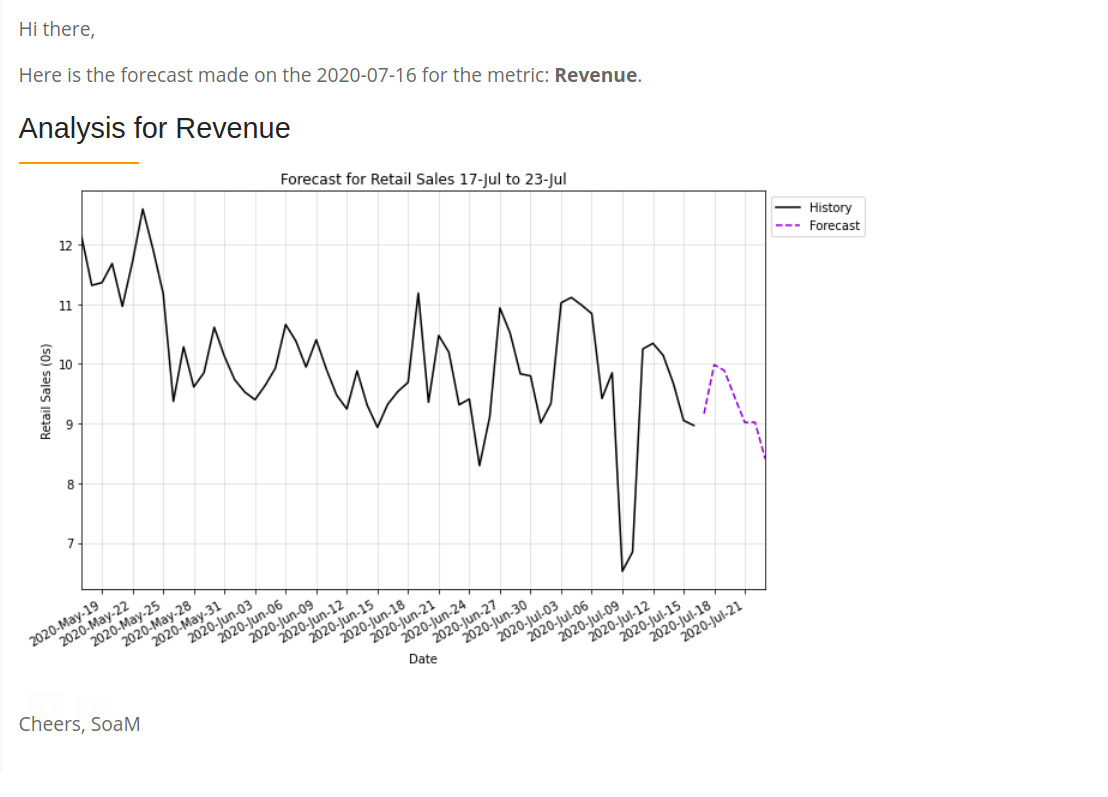

In [14]:
from IPython.display import display, Image

display(Image(filename='img/email_report.png'))

### Slack Report

The class `SlackReport` can send a summary of the results of your forecasts and its resulting plot. You'll just need a **Slack Token** defined in `settings.ini` (feel free to ask for the Mutt Bot's token!).

In [ ]:
slack_report = SlackReport('G010E2ZRC91', 'revenue')
slack_report.send_report(forecaster, plot_fn)

Here is how your report should look like:

In [ ]:
display(Image(filename='img/slack_report.png'))